### HW#2
2020741051 이재원(로봇학부)

# HW#6 Regularization

안녕하세요, 광운대학교 로봇학부의 오정현 교수입니다. 본 자료는 딥러닝 실습 수업을 위해 제작된 것입니다.

파이썬 문법
- 점프투파이썬(https://wikidocs.net/book/1) 참고

이번 과제는 딥러닝의 일반화 성능을 높이기 위한 Regularization을 해보는 것입니다.이미지 분류에 여러 가지 Regularization 기법을 적용해 보도록 하겠습니다. 대표적인 Regularization 기법으로 Dropout, Data augmentation, Batch Normalization 등이 있습니다.

이번 과제는 (https://www.tensorflow.org/tutorials/keras/classification?hl=ko)를 참고하면 좋습니다.

#1. Data Generation
Data는 mnist dataset을 이용하도록 하겠습니다. mnist dataset은 원래 60000개의 training set이 주어져 있지만 overfitting을 유도하기 위하여 1000개의 data만 이용하려고 합니다. 1000개의 data로 이루어진 x_train과 y_train을 만들어 보세요. 그리고 2000개로 이루어진 large_x_train, large_y_train을 만들어보세요. 그리고 training data의 다른 범위에서 200개로 이루어진 x_validation과 y_validation도 만들어 보세요.

In [1]:
import keras
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend

print(f"Keras Version : {keras.__version__}")
print(f"Tensorflow Version : {tf.__version__}")
print(f"GPU : {tf.test.is_gpu_available()}")

Keras Version : 2.8.0
Tensorflow Version : 2.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU : True


In [2]:
from __future__ import print_function
# 수정 kears -> tensorflow.keras
import tensorflow.keras as keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from keras import backend as K
from matplotlib import pyplot

batch_size = 28
num_classes = 10
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X_train, Y_train), (x_test,y_test) = mnist.load_data() # (data, label)

### START CODE HERE ###
x_train = X_train[0:1000]
y_train = Y_train[0:1000]
large_x_train = X_train[1000:3000] # 2000개
large_y_train = Y_train[1000:3000] # 2000개
x_validation = X_train[3000:3200]
y_validation = Y_train[3000:3200]
### END CODE HERE ###

print("x_validation shape:", x_validation.shape)
print("y_validation shape:", y_validation.shape)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    large_x_train = large_x_train.reshape(large_x_train.shape[0], 1, img_rows, img_cols)
    x_validation = x_validation.reshape(x_validation.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    large_x_train = large_x_train.reshape(large_x_train.shape[0], img_rows, img_cols, 1)
    x_validation = x_validation.reshape(x_validation.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
large_x_train = large_x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
large_x_train /= 255
x_validation /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
large_y_train = keras.utils.to_categorical(large_y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

assert large_x_train.shape[0]==2000
assert large_y_train.shape[0]==2000
assert x_train.shape[0]==1000
assert y_train.shape[0]==1000
assert x_validation.shape[0]==200
assert y_validation.shape[0]==200

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("large_x_train shape:", large_x_train.shape)
print("large_y_train shape:", large_y_train.shape)
print("x_validation shape:", x_validation.shape)
print("y_validation shape:", y_validation.shape)

x_validation shape: (200, 28, 28)
y_validation shape: (200,)
x_train shape: (1000, 28, 28, 1)
y_train shape: (1000, 10)
large_x_train shape: (2000, 28, 28, 1)
large_y_train shape: (2000, 10)
x_validation shape: (200, 28, 28, 1)
y_validation shape: (200, 10)


#2. 모델 생성
복습 차원에서 MLP 분류모델을 만들어 보도록 하겠습니다. 모델의 마지막 레이어에는 활성화 함수로 10개의 출력을 가지는 softmax를 달겠습니다. 이를 통해서 모델은 이미지안의 숫자가 0부터 9까지의 숫자중에 어디에 가까운지를 확률적으로 나타냅니다. 



다음과 같은 MLP 모델을 만들어 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| Flatten | (None, 784) | 0 |
| Dense | (None, 1024) | 803840 |
| Dense | (None, 1024) | 1049600 |
| Dense | (None, 1024) | 1049600 |
| Flatten | (None, 1024) | 0 |
| Dense | (None, 10) | 10250 |

In [3]:
model = Sequential()
### START CODE HERE ###
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))
### END CODE HERE ###

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
Total params: 2,913,290
Trainable params: 2,913,290
Non-

#3. Learning MLP
기본 MLP 분류모델을 학습해 보겠습니다. Overfitting은 Training data에 맞추어 과도하게 학습이 이루어져 Test data에서 높은 성능이 나지 않는 현상, 즉 Generalization 성능이 높지 않게 나타나는 현상을 의미합니다. 따라서 Overfitting이 발생하면 Training accuracy는 높지만 Test accuracy는 높지 않게 나타납니다. 

현재 모델이 overfitting이 발생하는지 체크해 보세요. 일부러 overfitting이 발생하도록 유도하였기 때문에 overfitting 현상이 나타나야 합니다.

In [4]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
weights = model.get_weights()

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
36/36 [==============================] - 1s 7ms/step - loss: 2.2911 - accuracy: 0.1500 - val_loss: 2.2683 - val_accuracy: 0.1500
Epoch 2/100
36/36 [==============================] - 0s 4ms/step - loss: 2.2809 - accuracy: 0.1700 - val_loss: 2.2607 - val_accuracy: 0.1650
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 2.2707 - accuracy: 0.1830 - val_loss: 2.2531 - val_accuracy: 0.1650
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 2.2606 - accuracy: 0.2010 - val_loss: 2.2455 - val_accuracy: 0.1700
Epoch 5/100
36/36 [==============================] - 0s 4ms/step - loss: 2.2506 - accuracy: 0.2170 - val_loss: 2.2378 - val_accuracy: 0.1850
Epoch 6/100
36/36 [==============================] - 0s 4ms/step - loss: 2.2405 - accuracy: 0.2290 - val_loss: 2.2302 - val_accuracy: 0.2000
Epoch 7/100
36/36 [==============================] - 0s 4ms/step - loss: 2.2305 - accuracy: 0.2410 - val_loss: 2.2225 - val_accuracy: 0.2100
Epoch 8/100
3

Epoch 59/100
36/36 [==============================] - 0s 4ms/step - loss: 1.6451 - accuracy: 0.7710 - val_loss: 1.7418 - val_accuracy: 0.6950
Epoch 60/100
36/36 [==============================] - 0s 4ms/step - loss: 1.6323 - accuracy: 0.7730 - val_loss: 1.7308 - val_accuracy: 0.6900
Epoch 61/100
36/36 [==============================] - 0s 4ms/step - loss: 1.6194 - accuracy: 0.7720 - val_loss: 1.7196 - val_accuracy: 0.6900
Epoch 62/100
36/36 [==============================] - 0s 4ms/step - loss: 1.6065 - accuracy: 0.7720 - val_loss: 1.7085 - val_accuracy: 0.6900
Epoch 63/100
36/36 [==============================] - 0s 4ms/step - loss: 1.5936 - accuracy: 0.7740 - val_loss: 1.6972 - val_accuracy: 0.6900
Epoch 64/100
36/36 [==============================] - 0s 4ms/step - loss: 1.5807 - accuracy: 0.7750 - val_loss: 1.6860 - val_accuracy: 0.6950
Epoch 65/100
36/36 [==============================] - 0s 4ms/step - loss: 1.5678 - accuracy: 0.7770 - val_loss: 1.6747 - val_accuracy: 0.6950
Epoch 

#4. Regularization
Overfitting이 발생한 모델에 다양한 Regularization 기법을 이용해 보도록 합시다.

4.1 Large Dataset

Training data가 충분하다면 overfitting 현상이 발생할 가능성이 줄어듭니다. 기본 MLP 분류 모델에서 large_x_train과 large_y_train을 이용하면 성능이 올라갈 것입니다. Generalization 성능이 올라갔나요?

In [5]:
#initialize weights
model.set_weights(weights)

large_model_history=model.fit(large_x_train, large_y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))

score = model.evaluate(x_test, y_test, verbose=0)
print('Largemodel Test loss:', score[0])
print('Largemodel Test accuracy:', score[1])

Epoch 1/100
72/72 [==============================] - 0s 4ms/step - loss: 2.2798 - accuracy: 0.1685 - val_loss: 2.2608 - val_accuracy: 0.1600
Epoch 2/100
72/72 [==============================] - 0s 4ms/step - loss: 2.2598 - accuracy: 0.2025 - val_loss: 2.2454 - val_accuracy: 0.1700
Epoch 3/100
72/72 [==============================] - 0s 4ms/step - loss: 2.2401 - accuracy: 0.2300 - val_loss: 2.2303 - val_accuracy: 0.1900
Epoch 4/100
72/72 [==============================] - 0s 4ms/step - loss: 2.2205 - accuracy: 0.2610 - val_loss: 2.2152 - val_accuracy: 0.2150
Epoch 5/100
72/72 [==============================] - 0s 4ms/step - loss: 2.2011 - accuracy: 0.3035 - val_loss: 2.2000 - val_accuracy: 0.2400
Epoch 6/100
72/72 [==============================] - 0s 4ms/step - loss: 2.1817 - accuracy: 0.3445 - val_loss: 2.1847 - val_accuracy: 0.2800
Epoch 7/100
72/72 [==============================] - 0s 3ms/step - loss: 2.1623 - accuracy: 0.3975 - val_loss: 2.1693 - val_accuracy: 0.3300
Epoch 8/100
7

Epoch 59/100
72/72 [==============================] - 0s 3ms/step - loss: 0.9919 - accuracy: 0.8420 - val_loss: 1.1279 - val_accuracy: 0.8200
Epoch 60/100
72/72 [==============================] - 0s 3ms/step - loss: 0.9751 - accuracy: 0.8415 - val_loss: 1.1115 - val_accuracy: 0.8250
Epoch 61/100
72/72 [==============================] - 0s 3ms/step - loss: 0.9588 - accuracy: 0.8425 - val_loss: 1.0952 - val_accuracy: 0.8300
Epoch 62/100
72/72 [==============================] - 0s 3ms/step - loss: 0.9430 - accuracy: 0.8465 - val_loss: 1.0793 - val_accuracy: 0.8350
Epoch 63/100
72/72 [==============================] - 0s 3ms/step - loss: 0.9276 - accuracy: 0.8445 - val_loss: 1.0641 - val_accuracy: 0.8350
Epoch 64/100
72/72 [==============================] - 0s 3ms/step - loss: 0.9126 - accuracy: 0.8465 - val_loss: 1.0489 - val_accuracy: 0.8450
Epoch 65/100
72/72 [==============================] - 0s 3ms/step - loss: 0.8981 - accuracy: 0.8495 - val_loss: 1.0345 - val_accuracy: 0.8550
Epoch 

##4.2 Dropout
Dropout은 쉽게 쓸 수 있는 Regularization 기법입니다. Layer 사이에 Dropout layer만 추가하면 되기 때문에 간편합니다. 다음과 같은 Dropout model을 만들어 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| Flatten | (None, 784) | 0 |
| Dense | (None, 1024) | 803840 |
| Dense | (None, 1024) | 1049600 |
| Dense | (None, 1024) | 1049600 |
| Dropout | (None, 1024) | 0 |
| Flatten | (None, 1024) | 0 |
| Dense | (None, 10) | 10250 |

In [6]:
dropout_model = Sequential()
### START CODE HERE ###
dropout_model.add(keras.layers.Flatten(input_shape=(28,28)))
dropout_model.add(keras.layers.Dense(1024))
dropout_model.add(keras.layers.Dense(1024))
dropout_model.add(keras.layers.Dense(1024))
dropout_model.add(keras.layers.Dropout(0.2))
dropout_model.add(keras.layers.Flatten())
dropout_model.add(keras.layers.Dense(10, activation='softmax'))
### END CODE HERE ###

dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 10)               

Dropout Model을 학습해 보겠습니다. Generalization 성능이 올라갔나요?

※Dropout을 적용한 Model은 일정확률로 신경망의 뉴런을 비활성화시키기 때문에, 오버피팅을 방지하는 효과가 있습니다. 하지만 비활성화로 인해서  학습속도가 떨어진다는 단점이 존재합니다. 그 때문에 test accuracy는 같은 학습파라미터 조건에서 기존모델보다 더 낮을 수 있습니다. 

기존모델과 dropout을 적용한 모델에 대해서, train 데이터와 test데이터에 대한 accuracy차이를 주목해보시면 좋을 것같습니다!

In [7]:
dropout_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

dropout_model_history=dropout_model.fit(large_x_train, large_y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))

score = dropout_model.evaluate(x_test, y_test, verbose=0)
print('Dropout model Test loss:', score[0])
print('Dropout model Test accuracy:', score[1])

Epoch 1/100
72/72 [==============================] - 1s 4ms/step - loss: 2.2806 - accuracy: 0.1390 - val_loss: 2.2048 - val_accuracy: 0.1850
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 2.1352 - accuracy: 0.2450 - val_loss: 2.0871 - val_accuracy: 0.3050
Epoch 3/100
72/72 [==============================] - 0s 3ms/step - loss: 2.0038 - accuracy: 0.3645 - val_loss: 1.9822 - val_accuracy: 0.4000
Epoch 4/100
72/72 [==============================] - 0s 3ms/step - loss: 1.8906 - accuracy: 0.4650 - val_loss: 1.8857 - val_accuracy: 0.5350
Epoch 5/100
72/72 [==============================] - 0s 3ms/step - loss: 1.7822 - accuracy: 0.5470 - val_loss: 1.7961 - val_accuracy: 0.6100
Epoch 6/100
72/72 [==============================] - 0s 3ms/step - loss: 1.6806 - accuracy: 0.6010 - val_loss: 1.7138 - val_accuracy: 0.6500
Epoch 7/100
72/72 [==============================] - 0s 3ms/step - loss: 1.6028 - accuracy: 0.6465 - val_loss: 1.6361 - val_accuracy: 0.6800
Epoch 8/100
7

Epoch 59/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4744 - accuracy: 0.8815 - val_loss: 0.5767 - val_accuracy: 0.8600
Epoch 60/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4636 - accuracy: 0.8870 - val_loss: 0.5721 - val_accuracy: 0.8600
Epoch 61/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4618 - accuracy: 0.8845 - val_loss: 0.5675 - val_accuracy: 0.8600
Epoch 62/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4542 - accuracy: 0.8875 - val_loss: 0.5631 - val_accuracy: 0.8600
Epoch 63/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4493 - accuracy: 0.8885 - val_loss: 0.5593 - val_accuracy: 0.8600
Epoch 64/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4449 - accuracy: 0.8825 - val_loss: 0.5556 - val_accuracy: 0.8600
Epoch 65/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4411 - accuracy: 0.8875 - val_loss: 0.5508 - val_accuracy: 0.8600
Epoch 

##4.3 BatchNormalization
BatchNormalization(BN)은 쉽게 쓸 수 있는 Regularization 기법입니다. Layer 사이에 BN layer만 추가하면 되기 때문에 간편합니다. 다음과 같은 BN model을 만들어 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| Flatten | (None, 784) | 0 |
| Dense | (None, 1024) | 803840 |
| BatchNormalization | (None, 1024) | 4096 |
| Activation | (None, 1024) | 0 |
| Dense | (None, 1024) | 1049600 |
| BatchNormalization | (None, 1024) | 4096 |
| Activation | (None, 1024) | 0 |
| Dense | (None, 1024) | 1049600 |
| BatchNormalization | (None, 1024) | 4096 |
| Activation | (None, 1024) | 0 |
| Flatten | (None, 1024) | 0 |
| Dense | (None, 10) | 10250 |

In [8]:
bn_model = Sequential()
### START CODE HERE ###
bn_model.add(keras.layers.Flatten(input_shape=(28,28)))
bn_model.add(keras.layers.Dense(1024))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation(activation='relu'))
bn_model.add(keras.layers.Dense(1024))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation(activation='relu'))
bn_model.add(keras.layers.Dense(1024))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation(activation='relu'))
bn_model.add(keras.layers.Flatten())
bn_model.add(keras.layers.Dense(10, activation='softmax'))
### END CODE HERE ###
bn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              803840    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                      

BN Model을 학습해 보겠습니다. Generalization 성능이 올라갔나요?

In [9]:
bn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
bn_model_history=bn_model.fit(large_x_train, large_y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))

score = bn_model.evaluate(x_test, y_test, verbose=0)
print('BN model Test loss:', score[0])
print('BN model Test accuracy:', score[1])

Epoch 1/100
72/72 [==============================] - 1s 8ms/step - loss: 2.7028 - accuracy: 0.1115 - val_loss: 2.2738 - val_accuracy: 0.1100
Epoch 2/100
72/72 [==============================] - 0s 7ms/step - loss: 2.4837 - accuracy: 0.1660 - val_loss: 2.2207 - val_accuracy: 0.1700
Epoch 3/100
72/72 [==============================] - 0s 6ms/step - loss: 2.3076 - accuracy: 0.2115 - val_loss: 2.1215 - val_accuracy: 0.2350
Epoch 4/100
72/72 [==============================] - 0s 6ms/step - loss: 2.1500 - accuracy: 0.2705 - val_loss: 1.9975 - val_accuracy: 0.3300
Epoch 5/100
72/72 [==============================] - 0s 7ms/step - loss: 1.9853 - accuracy: 0.3275 - val_loss: 1.8820 - val_accuracy: 0.3950
Epoch 6/100
72/72 [==============================] - 0s 6ms/step - loss: 1.8643 - accuracy: 0.3800 - val_loss: 1.7811 - val_accuracy: 0.4200
Epoch 7/100
72/72 [==============================] - 0s 6ms/step - loss: 1.7617 - accuracy: 0.4160 - val_loss: 1.6899 - val_accuracy: 0.4500
Epoch 8/100
7

Epoch 59/100
72/72 [==============================] - 0s 7ms/step - loss: 0.3334 - accuracy: 0.9330 - val_loss: 0.4777 - val_accuracy: 0.8750
Epoch 60/100
72/72 [==============================] - 0s 7ms/step - loss: 0.3381 - accuracy: 0.9280 - val_loss: 0.4730 - val_accuracy: 0.8750
Epoch 61/100
72/72 [==============================] - 0s 7ms/step - loss: 0.3217 - accuracy: 0.9350 - val_loss: 0.4703 - val_accuracy: 0.8750
Epoch 62/100
72/72 [==============================] - 0s 7ms/step - loss: 0.3280 - accuracy: 0.9350 - val_loss: 0.4664 - val_accuracy: 0.8750
Epoch 63/100
72/72 [==============================] - 0s 7ms/step - loss: 0.3316 - accuracy: 0.9285 - val_loss: 0.4618 - val_accuracy: 0.8750
Epoch 64/100
72/72 [==============================] - 0s 7ms/step - loss: 0.3100 - accuracy: 0.9355 - val_loss: 0.4571 - val_accuracy: 0.8750
Epoch 65/100
72/72 [==============================] - 0s 7ms/step - loss: 0.3218 - accuracy: 0.9310 - val_loss: 0.4538 - val_accuracy: 0.8750
Epoch 

##4.4 Final Model
지금까지 썼던 Regularization 기법들을 종합선물세트로 적용해 봅시다. 다음과 같은 Final model을 만들어 보세요.

| Layer (type) | Output Shape | Param # |
|------|------|------|
| Flatten | (None, 784) | 0 |
| Dense | (None, 1024) | 803840 |
| BatchNormalization | (None, 1024) | 4096 |
| Activation | (None, 1024) | 0 |
| Dense | (None, 1024) | 1049600 |
| BatchNormalization | (None, 1024) | 4096 |
| Activation | (None, 1024) | 0 |
| Dense | (None, 1024) | 1049600 |
| BatchNormalization | (None, 1024) | 4096 |
| Activation | (None, 1024) | 0 |
| Dropout | (None, 1024) | 0 |
| Flatten | (None, 1024) | 0 |
| Dense | (None, 10) | 10250 |

In [10]:
final_model = Sequential()
### START CODE HERE ###
final_model.add(Flatten(input_shape=(28,28)))
final_model.add(Dense(1024))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Dense(1024))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Dense(1024))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Dropout(0.3))
final_model.add(Flatten(input_shape=(1024,)))
final_model.add(Dense(10,activation='softmax'))
### END CODE HERE ###
final_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 1024)              803840    
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                      

Final Model을 학습해 보겠습니다. Generalization 성능이 올라갔나요?

In [11]:
final_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
final_model_history=final_model.fit(large_x_train, large_y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))

score = final_model.evaluate(x_test, y_test, verbose=0)
print('Final model Test loss:', score[0])
print('Final model Test accuracy:', score[1])

Epoch 1/100
72/72 [==============================] - 1s 9ms/step - loss: 2.7008 - accuracy: 0.1090 - val_loss: 2.2644 - val_accuracy: 0.1550
Epoch 2/100
72/72 [==============================] - 0s 7ms/step - loss: 2.5620 - accuracy: 0.1465 - val_loss: 2.2107 - val_accuracy: 0.1600
Epoch 3/100
72/72 [==============================] - 0s 7ms/step - loss: 2.3804 - accuracy: 0.1815 - val_loss: 2.1125 - val_accuracy: 0.2200
Epoch 4/100
72/72 [==============================] - 0s 7ms/step - loss: 2.2341 - accuracy: 0.2380 - val_loss: 1.9905 - val_accuracy: 0.3150
Epoch 5/100
72/72 [==============================] - 0s 7ms/step - loss: 2.1105 - accuracy: 0.2780 - val_loss: 1.8663 - val_accuracy: 0.3800
Epoch 6/100
72/72 [==============================] - 0s 7ms/step - loss: 2.0251 - accuracy: 0.3035 - val_loss: 1.7570 - val_accuracy: 0.4750
Epoch 7/100
72/72 [==============================] - 0s 6ms/step - loss: 1.9061 - accuracy: 0.3470 - val_loss: 1.6637 - val_accuracy: 0.4900
Epoch 8/100
7

Epoch 59/100
72/72 [==============================] - 0s 7ms/step - loss: 0.4740 - accuracy: 0.8680 - val_loss: 0.5418 - val_accuracy: 0.8450
Epoch 60/100
72/72 [==============================] - 0s 7ms/step - loss: 0.4890 - accuracy: 0.8485 - val_loss: 0.5363 - val_accuracy: 0.8500
Epoch 61/100
72/72 [==============================] - 0s 6ms/step - loss: 0.4720 - accuracy: 0.8690 - val_loss: 0.5308 - val_accuracy: 0.8500
Epoch 62/100
72/72 [==============================] - 0s 7ms/step - loss: 0.4479 - accuracy: 0.8735 - val_loss: 0.5263 - val_accuracy: 0.8500
Epoch 63/100
72/72 [==============================] - 0s 7ms/step - loss: 0.4411 - accuracy: 0.8830 - val_loss: 0.5216 - val_accuracy: 0.8500
Epoch 64/100
72/72 [==============================] - 1s 7ms/step - loss: 0.4306 - accuracy: 0.8825 - val_loss: 0.5163 - val_accuracy: 0.8550
Epoch 65/100
72/72 [==============================] - 0s 7ms/step - loss: 0.4366 - accuracy: 0.8825 - val_loss: 0.5133 - val_accuracy: 0.8450
Epoch 

(optional) Training data가 늘어나면 regularization 효과가 나는 것을 보였습니다. 쉽게 training data를 늘릴 수 있는 방법은 data augmentation 입니다. 이 방법은 기존 training data를 적절히 rotating, flipping, scaling, shifting 하여 training data 수를 늘리는 것입니다. data augmentation의 regularization 효과를 테스트해 보세요. 또한 뉴럴 네트워크의 노드 개수나 층수를 바꿔서 성능을 올려보는 것도 테스트해보세요.

## My Data Augmentation with ImageDataGenerator (Optional)
참고 자료 : 
- https://github.com/mohit1997/PAF/blob/master/Experiments/FMNIST/utils.py
- https://keras.io/ko/preprocessing/image/

Images after Augmentation :  2000


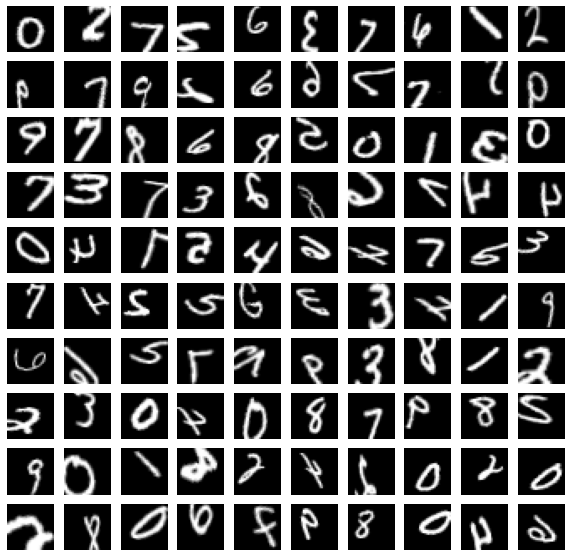

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, 
                                                             samplewise_center=False, 
                                                             featurewise_std_normalization=False, 
                                                             samplewise_std_normalization=False, 
                                                             zca_whitening=False,
                                                             zca_epsilon=1e-06,
                                                               
                                                             # Rotation
                                                             rotation_range=20,
                                                               
                                                             # 평행 이동
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                            
                                                             brightness_range=None, 
                                                             shear_range=0.2, 
                                                               
                                                             # 랜덤 확대 범위
                                                             zoom_range=0.3, 
                                                               
                                                             channel_shift_range=0.0, 
                                                             fill_mode='nearest', 
                                                             cval=0.0,
                                                               
                                                             # 수평 회전
                                                             horizontal_flip=True,
                                                             
                                                             vertical_flip=False, 
                                                             rescale=None, 
                                                             preprocessing_function=None, 
                                                             data_format=None, 
                                                             validation_split=0.0, dtype=None)

augment_size = 1000;

randidx = np.random.randint(x_train.shape[0], size=augment_size)
x_augmented = x_train[randidx].copy()
y_augmented = y_train[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

aug_x_train = np.concatenate((x_train, x_augmented))
aug_y_train = np.concatenate((y_train, y_augmented))

print('Images after Augmentation : ', aug_x_train.shape[0])

# Augmentated Data
pyplot.figure(figsize=(10, 10))
for c in range(100):
  pyplot.subplot(10,10,c+1)
  pyplot.axis('off')
  pyplot.imshow(x_augmented[c].reshape(28,28), cmap='gray')
pyplot.show()

In [14]:
my_model = Sequential()

my_model.add(Flatten(input_shape=(28,28)))
my_model.add(Dense(1024))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Dense(2048))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Dense(4096))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Dropout(0.3))
my_model.add(Dense(4096))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Flatten(input_shape=(1024,)))
my_model.add(Dense(10,activation='softmax'))

my_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 1024)              803840    
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 2048)              2099200   
                                                                 
 batch_normalization_7 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [15]:
my_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
my_model_history=my_model.fit(aug_x_train, aug_y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))

score = my_model.evaluate(x_test, y_test, verbose=0)
print('My model Test loss:', score[0])
print('My model Test accuracy:', score[1])

Epoch 1/100
72/72 [==============================] - 2s 15ms/step - loss: 2.6832 - accuracy: 0.1050 - val_loss: 2.2996 - val_accuracy: 0.1300
Epoch 2/100
72/72 [==============================] - 1s 13ms/step - loss: 2.4353 - accuracy: 0.1515 - val_loss: 2.2308 - val_accuracy: 0.1550
Epoch 3/100
72/72 [==============================] - 1s 13ms/step - loss: 2.2424 - accuracy: 0.2160 - val_loss: 2.0461 - val_accuracy: 0.2750
Epoch 4/100
72/72 [==============================] - 1s 14ms/step - loss: 2.1135 - accuracy: 0.2660 - val_loss: 1.8038 - val_accuracy: 0.4200
Epoch 5/100
72/72 [==============================] - 1s 13ms/step - loss: 1.9468 - accuracy: 0.3375 - val_loss: 1.5846 - val_accuracy: 0.5250
Epoch 6/100
72/72 [==============================] - 1s 13ms/step - loss: 1.9043 - accuracy: 0.3665 - val_loss: 1.4207 - val_accuracy: 0.6100
Epoch 7/100
72/72 [==============================] - 1s 13ms/step - loss: 1.7827 - accuracy: 0.3990 - val_loss: 1.3007 - val_accuracy: 0.6400
Epoch 

72/72 [==============================] - 1s 14ms/step - loss: 0.6915 - accuracy: 0.8030 - val_loss: 0.5425 - val_accuracy: 0.8500
Epoch 59/100
72/72 [==============================] - 1s 13ms/step - loss: 0.6952 - accuracy: 0.8125 - val_loss: 0.5393 - val_accuracy: 0.8500
Epoch 60/100
72/72 [==============================] - 1s 13ms/step - loss: 0.6852 - accuracy: 0.8195 - val_loss: 0.5363 - val_accuracy: 0.8500
Epoch 61/100
72/72 [==============================] - 1s 13ms/step - loss: 0.6722 - accuracy: 0.8135 - val_loss: 0.5351 - val_accuracy: 0.8500
Epoch 62/100
72/72 [==============================] - 1s 14ms/step - loss: 0.6567 - accuracy: 0.8325 - val_loss: 0.5316 - val_accuracy: 0.8500
Epoch 63/100
72/72 [==============================] - 1s 13ms/step - loss: 0.6525 - accuracy: 0.8285 - val_loss: 0.5283 - val_accuracy: 0.8500
Epoch 64/100
72/72 [==============================] - 1s 13ms/step - loss: 0.6356 - accuracy: 0.8325 - val_loss: 0.5243 - val_accuracy: 0.8500
Epoch 65/100